In [1]:
using Pkg

function install_missing_package(package_name::String)
    if !haskey(Pkg.installed(), package_name)
        println("Package \""*package_name*"\" is missing.")
        println("Installing package...")
        Pkg.add(package_name)
    else
        println("Package \""*package_name*"\" is already installed.")
    end
     println("=======================================================")
end

install_missing_package("Eirene")
install_missing_package("DelimitedFiles")
install_missing_package("PyCall")
install_missing_package("Plots")

Package "Eirene" is already installed.
Package "DelimitedFiles" is already installed.
Package "PyCall" is already installed.
Package "Plots" is already installed.


# Load packages
Notice 1: Eirene is precompiling at every kernel restart

Notice 2: There are some warnings while precompiling Eirene. This is because Eirene dependencies have some unfixed issues. Eirene should work despite the warnings. 

In [2]:
using DelimitedFiles
using PyCall
using Plots
using Eirene

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-17579130459161668323\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-13436259781066852442\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-17579130459161668323\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

# Load file:

## a) from ".npy" file with numpy:
Notice: "SyllableEncoding.npy" is not included in the repository

In [4]:
PyAny = py"""
        import numpy as np
        import matplotlib.pyplot as plt"""

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /Users/emil/.julia/packages/PyCall/ttONZ/src/pyeval.jl:39 =# @pysym(:PyEval_EvalCode), PyPtr, (PyPtr, PyPtr, PyPtr), o, globals, locals))))) <class 'ModuleNotFoundError'>
ModuleNotFoundError("No module named 'numpy'")
  File "/Users/emil/.julia/packages/PyCall/ttONZ/src/pyeval.jl", line 1, in <module>
    const Py_single_input = 256  # from Python.h


In [3]:
        file_name = "SyllableEncoding.npy"

        py_symm_matrtix = np.load(file_name, allow_pickle=True, encoding="latin1")
        """
py_symmetric_matrtix = PyArray(py"py_symm_matrtix"o)
symmetric_matrix = Array(py_symmetric_matrtix)

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /Users/emil/.julia/packages/PyCall/ttONZ/src/pyeval.jl:39 =# @pysym(:PyEval_EvalCode), PyPtr, (PyPtr, PyPtr, PyPtr), o, globals, locals))))) <class 'ModuleNotFoundError'>
ModuleNotFoundError("No module named 'numpy'")
  File "/Users/emil/.julia/packages/PyCall/ttONZ/src/pyeval.jl", line 1, in <module>
    const Py_single_input = 256  # from Python.h


## b) from ".txt" or ".csv" file with julia:

In [7]:
file_name = "spectrogram_matrix.txt"
symmetric_matrix = readdlm( file_name, ',', Float64, '\n')

32×32 Array{Float64,2}:
 0.0      1.3522   1.62285  1.47847  …  1.93804  1.66726  1.853    1.90182
 1.3522   0.0      1.73234  1.46807     2.06516  1.71553  1.77074  1.95664
 1.62285  1.73234  0.0      1.70526     2.05393  1.79255  2.0002   1.89861
 1.47847  1.46807  1.70526  0.0         2.07699  1.71884  1.83823  1.90327
 1.37349  1.47053  1.75287  1.41547     1.9355   1.75601  1.81409  1.86247
 1.39788  1.45281  1.62396  1.4909   …  2.03467  1.60363  1.69471  1.7609 
 1.44022  1.41236  1.62501  1.38583     1.99436  1.7701   1.66635  1.7886 
 1.53625  1.37663  1.68134  1.48509     1.97048  1.70587  1.78721  1.95302
 3.00828  3.08385  2.83353  2.95563     2.68706  2.83601  2.82782  2.78859
 1.6012   1.58779  1.78948  1.70471     1.96338  1.59898  1.75756  1.87189
 1.35415  1.50983  1.72541  1.603    …  2.03186  1.69264  1.80504  1.8643 
 2.11121  2.09984  2.14925  2.08285     2.25694  2.14875  2.15931  2.39548
 2.85487  2.89919  2.6875   2.88362     2.48009  2.72218  2.75646  2.72632
 

# Preprocessing

## Ordering of the matrix

In [8]:
function get_ordered_matrix(input_matrix)
    mat_size = size(input_matrix,1)
    ordered_matrix = zeros(Int, mat_size, mat_size)

    # ====
    # Get all cartesian indices from input matrix
    matrix_indices = CartesianIndices((1:mat_size, 1:mat_size))
    # Filter out indices below diagonal
    matrix_indices = findall(x->x[1]>x[2], matrix_indices)

    # Count elements above diagonal
    repetition_number = Int(ceil((mat_size * (mat_size-1))/2))
   
    # Get all values which will be sorted
    sorted_values = input_matrix[matrix_indices]

    # Sort indices by values (starting with lowest)
    ordered_indices = sort!([1:repetition_number;],
                        by=i->(sorted_values[i],matrix_indices[i]))

    for k=1:repetition_number
        next_position = ordered_indices[k]
        matrix_index = matrix_indices[next_position]
        ordered_matrix[matrix_index] = k
        ordered_matrix[matrix_index[2], matrix_index[1]] = k
    end

    # ====
    # Check the ordering
    non_zero_input = findall(x->x!=0,input_matrix)
    min_orig = findmin(input_matrix[non_zero_input])[2]
    max_new = findall(x->x==1,ordered_matrix)[1]
    println("Check:")
    println("\tOriginal minimal value was at position: \t"*string(non_zero_input[min_orig]))
    println("\tAfter ordering the first index value is at position: \t"*string(max_new))
    return ordered_matrix
end

get_ordered_matrix (generic function with 1 method)

### Simple check of ordering

In [9]:
a = [ 0 11 12;
     11  0 13;
     12 13  0];
get_ordered_matrix(a)

Check:
	Original minimal value was at position: 	CartesianIndex(2, 1)
	After ordering the first index value is at position: 	CartesianIndex(2, 1)


3×3 Array{Int64,2}:
 0  1  2
 1  0  3
 2  3  0

## Order input matrix

In [12]:
las_index = 32
ordered_matrix = get_ordered_matrix(symmetric_matrix[1:las_index,1:las_index])

Check:
	Original minimal value was at position: 	CartesianIndex(2, 1)
	After ordering the first index value is at position: 	CartesianIndex(2, 1)


32×32 Array{Int64,2}:
   0    1   36   20    4    9   13   26  …  302  144  138   87   42   73   82
   1    0   52   18   19   15   11    5     313  130  154  102   49   59   89
  36   52    0   47   54   37   39   43     271  121  141  100   65   95   81
  20   18   47    0   12   22    6   21     288  127  146  103   50   71   83
   4   19   54   12    0    8    2   28     310  124  155   86   55   67   75
   9   15   37   22    8    0   10   23  …  307  126  151   98   34   45   57
  13   11   39    6    2   10    0   14     303  123  140   93   58   41   63
  26    5   43   21   28   23   14    0     285  125  150   91   48   61   88
 206  217  184  200  209  207  208  193     205  158  181  166  185  183  178
  32   30   64   46   40   27   29   38     269  136  149   90   31   56   77
   3   24   51   33   16   25    7   17  …  304  122  135   96   44   66   76
 108  106  112  104  118  107  114  105     280  165  159  119  111  113  134
 189  195  167  192  190  194  191  171   

# Topological analysis

## Use Eirene

In [13]:
maximal_dimension = 3

persistance_analysis = eirene(ordered_matrix,maxdim=maximal_dimension)

Dict{String,Any} with 12 entries:
  "symmat"   => [450 443 … 0 0; 443 450 … 0 0; … ; 0 0 … 450 14; 0 0 … 14 450]
  "maxnz"    => [0, 329, 4187, 29454, 167001, 725284, 2509151, 0]
  "firstv"   => Array{Int64,1}[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  24, 25, 26, 2…
  "cyclerep" => Array{Array{Int64,1},1}[[], [[19, 20], [25, 29], [6, 17], [19, …
  "phi"      => Array{Int64,1}[[], [370, 430, 146, 373, 423, 371, 345, 89, 11, …
  "plo"      => Array{Int64,1}[[], [20, 29, 17, 23, 28, 21, 18, 9, 12, 14  …  2…
  "ocg2rad"  => [449.0, 448.0, 447.0, 446.0, 445.0, 444.0, 443.0, 442.0, 441.0,…
  "farfaces" => Array{Int64,1}[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  23, 24, 25, 2…
  "nvl2ovl"  => [7, 11, 8, 1, 10, 30, 6, 5, 3, 2  …  26, 22, 24, 20, 25, 23, 19…
  "input"    => Dict{String,Any}("genera"=>[0 1 … 73 82; 1 0 … 59 89; … ; 73 59…
  "tid"      => Array{Int64,1}[[], [20, 29, 17, 23, 28, 21, 18, 9, 12, 14  …  1…
  "grain"    => Array{Int64,1}[[450, 450, 450, 450, 450, 450, 450, 450, 450, 45…

## Compute Betti curves

In [15]:
minimal_betti = 1
maximal_betti = 3

bettis  = Matrix{Float64}[]
for d =minimal_betti:(maximal_betti+1)
    result = betticurve(persistance_analysis, dim=d)
    push!(bettis, result)
end
# bettis

## Plot betti curves

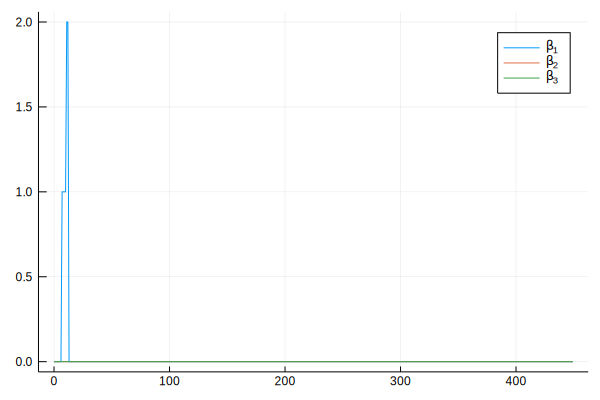

In [16]:
plot_ref = plot(title="");

for p = (minimal_betti):(maximal_betti)
    plot!(bettis[p][:,1], bettis[p][:,2], label="\\beta_"*string(p),)
end

plot_ref

## Plot heatmap of ordering matrix

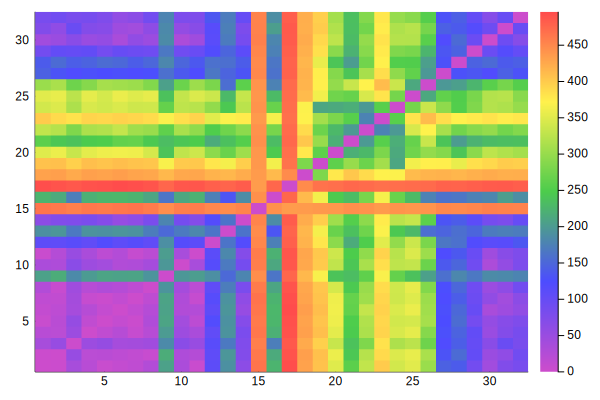

In [17]:

heatmap(ordered_matrix,  color=:lightrainbow)

In [ ]:
0. Przejrzec to co jest
1. Porownac metody porownywania spike trains
2. Zwikszyć ilosc kanalow
3. Porownac copuled i decopuled
